In [116]:
import gym
import gridworld as gw
import blackjack as bj
import numpy as np
import pprint
import sys
if "../" not in sys.path:
  sys.path.append("../") 

In [5]:
fz4x4N=gym.envs.toy_text.frozen_lake.FrozenLakeEnv(map_name=None,size=12,is_slippery=False)
fz4x4N.render()


SFFHHFFHHHFH
FFFFFFFFFFFF
FHFHFFHFFFFF
FFFFHFFFFFFF
FFFFFFHHFFFF
FFFFHFFFFFFF
FFFFFHFFFFFF
FFFFFFFHHFHF
HHFFFFFFFFFF
FFFHHFFHFFFF
FFFFFFFHFFFF
FHHFFFFFFHFG


In [15]:
pp = pprint.PrettyPrinter(indent=2)


In [48]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    while True:
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

In [8]:
# Taken from Policy Evaluation Exercise!

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [9]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=.99):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    i=0
    while True:
        i+=1
        #print(i)
        # Evaluate the current policy
        V = policy_eval_fn(policy, env, discount_factor)
        
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the currect policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable or i>10000:
            return V,[np.argmax(i) for i in policy],i

In [2]:
import cs7641assn4 as a4
import time
import gym
import gridworld as gw
import blackjack as bj
import numpy as np
import pprint
import sys
import matplotlib.pyplot as plt
from importlib import reload  # Python 3.4+ only.

if "../" not in sys.path:
  sys.path.append("../") 

In [5]:
def run_algo(algo,slip=False,ranges=5,in_gw=None):
    epsilon = 1e-8 # convergence threshold for policy/value iteration
    gamma = .8 # discount parameter for past policy/value iterations
    max_iter = 10000 # maximum iterations for slowly converging policy/value iteration 
    slip
    
    policy_times={}
    pi_V, pi_policy, pi_epochs={},{},{}
    if in_gw:
        fz_gw=in_gw
    else:
        fz_gw={}
    for i in range(4,16):
        policy_times[i]=[]
        if in_gw==None:
            fz_gw[i]=[]
        pi_V[i], pi_policy[i], pi_epochs[i]=[],[],[]
        for j in range(0,ranges):
            if in_gw==None:
                fz_gw[i].append(gym.envs.toy_text.frozen_lake.FrozenLakeEnv(map_name=None,size=i,is_slippery=slip,p=.89))
            start=time.time()
            if algo in [a4.policy_iteration,policy_improvement]:
                pi_V_t, pi_policy_t, pi_epochs_t=algo(fz_gw[i][j])#, epsilon=epsilon,gamma=gamma, max_iter=max_iter, report=True)
                policy_times[i].append(time.time()-start)

            else:
                pi_V_t,pi_epochs_t=algo(fz_gw[i][j], epsilon=epsilon, 
                                                             gamma=gamma, max_iter=max_iter, report=True)
                policy_times[i].append(time.time()-start)
                pi_policy_t=a4.value_to_policy(fz_gw[i][j], V=pi_V_t, gamma=gamma)
            pi_V[i].append(pi_V_t)
            pi_policy[i].append(pi_policy_t)
            pi_epochs[i].append(pi_epochs_t)
        fz_gw[i][j].render()
        a4.matprint(a4.print_value(pi_V[i][j], width=i, height=i))
        pi_policy_arrows = a4.print_policy(pi_policy[i][j], width=i, height=i)
        # Display policy
        a4.matprint(pi_policy_arrows)                               

    return fz_gw,policy_times,pi_V,pi_policy,pi_epochs
    

In [10]:
#fz_gw,policy_times,pi_V,pi_policy,pi_epochs =run_algo(a4.policy_iteration,slip=False,ranges=5)
fz_gw_p,policy_times_p,pi_V_p,pi_policy_p,pi_epochs_p =run_algo(a4.valueIteration,slip=True,ranges=5)
fz_gw,policy_times,pi_V,pi_policy,pi_epochs =run_algo(a4.policy_iteration,slip=True,ranges=5,in_gw=fz_gw_p)




Value iteration converged after  41 epochs
Value iteration converged after  41 epochs
Value iteration converged after  51 epochs
Value iteration converged after  45 epochs
Value iteration converged after  40 epochs

SFFF
FFFF
FFFF
FFFG
0.0743  0.1022   0.139  0.1672  
0.1022   0.142  0.2151  0.2927  
 0.139  0.2151  0.3719  0.5898  
0.1672  0.2927  0.5898       0  
→  →  →  →  
↓  ↓  ↓  ↓  
↓  →  ↓  ↓  
↓  →  →  ←  
Value iteration converged after  52 epochs
Value iteration converged after  45 epochs
Value iteration converged after  42 epochs
Value iteration converged after  42 epochs
Value iteration converged after  46 epochs

SFFFF
FFFFF
FFFFF
FFFFF
FFFHG
 0.017  0.0265  0.0406  0.0572  0.0703  
0.0203  0.0323  0.0544  0.0869  0.1231  
0.0234  0.0403  0.0766  0.1456  0.2515  
0.0239  0.0423  0.0873  0.2077   0.546  
  0.02   0.031   0.043       0       0  
↓  →  →  →  →  
↓  →  →  →  ↓  
↓  →  →  →  ↓  
↑  →  →  ↑  →  
→  →  ←  ←  ←  
Value iteration converged after  47 epochs
Value 

Value iteration converged after  52 epochs
Value iteration converged after  52 epochs
Value iteration converged after  52 epochs
Value iteration converged after  52 epochs
Value iteration converged after  54 epochs

SFFFFFFFFFFFF
FFHHFFFFFFFFF
FFHFFHFFFFFFF
FFFHFFFFHFHFF
FFFFFFFFHFFFF
FFFFFFFHFFFFF
FHFFFFFFFFFFF
FFFFFFFFFFFFF
FFFFFFFFFFFFF
FFFFFHHFFHFFF
FFFFFFFFFFFFF
FFFFFFFFFFFFF
FFFHFFFFFFHFG
     0       0       0       0       0       0  0.0001  0.0001  0.0001  0.0002  0.0003  0.0004  0.0005  
     0       0       0       0       0       0  0.0001  0.0001  0.0002  0.0003  0.0004  0.0007  0.0008  
     0       0       0       0       0       0  0.0001  0.0001  0.0002  0.0004  0.0006  0.0013  0.0016  
     0       0       0       0  0.0001  0.0001  0.0001  0.0001       0  0.0008       0  0.0026  0.0031  
     0       0  0.0001  0.0001  0.0002  0.0002  0.0003  0.0001       0  0.0026  0.0041  0.0053   0.006  
     0       0  0.0001  0.0002  0.0003  0.0005  0.0006       0  0.0026  0.004


SFFFFHF
FFFFFFF
FFFFFFH
FFFFHFF
HFFFFHF
FFFFFFF
HFFFFFG
0.0022  0.0027  0.0031  0.0031  0.0028       0  0.0013  
0.0034  0.0043  0.0053  0.0055  0.0047  0.0048  0.0022  
0.0051  0.0075  0.0101  0.0108  0.0071  0.0113       0  
0.0066  0.0129  0.0194  0.0233      -0  0.0303  0.1024  
     0  0.0216  0.0366  0.0572  0.0696       0  0.2512  
0.0115  0.0315  0.0583  0.1084  0.2039  0.3682  0.5884  
     0  0.0382  0.0736  0.1442  0.2881  0.5884       0  
↓  →  →  ←  ←  ←  →  
↓  ↓  ↓  ↓  ↓  ↓  ↑  
↓  ↓  ↓  ↓  ↑  ←  ←  
↑  →  ↓  ←  ←  →  ↓  
←  →  ↓  ↓  ←  ←  →  
↓  →  →  ↓  ↓  ↓  ↓  
←  →  →  →  →  →  ←  

SFFFHFFF
FFFFFHFF
FFFHHFFF
FFFFFFFF
FHFFFFFF
HHHFFFFF
FHFFFFFF
FFFFHFFG
0.0006  0.0007  0.0007  0.0004       0  0.0039  0.0107   0.012  
0.0009  0.0011  0.0013  0.0005  0.0001       0  0.0175  0.0211  
0.0013   0.002   0.003       0      -0  0.0214  0.0337  0.0405  
0.0016  0.0031   0.008  0.0174    0.03  0.0467  0.0646  0.0776  
0.0006      -0  0.0094  0.0273  0.0486  0.0804  0.1179  0


SHFFFFFFFHHFFF
FFFFFFHFHFFFFF
FFFFFHFFFFFFFF
FFFFFFFFFFFFFF
FFHFFFFFFFFFFF
FFFFFHFFFFFFFF
FFFFFFFHHFFFFF
FFFFFHFFFFFFFF
FHFFFFFFFFFHFF
FFFHFFFHFFFFFF
FFFFFFFFFFFFFF
HFFHFFFFHFHFFF
FFFFFHFFFFFFFF
FFFFFFFFFFHFHG
0  0  0       0       0       0       0       0       0       0       0  0.0002  0.0002  0.0002  
0  0  0       0       0       0       0       0       0  0.0001  0.0002  0.0003  0.0003  0.0003  
0  0  0       0       0       0       0  0.0001  0.0001  0.0002  0.0003  0.0005  0.0006  0.0006  
0  0  0       0       0       0  0.0001  0.0001  0.0002  0.0004  0.0006  0.0008   0.001  0.0012  
0  0  0       0       0       0  0.0001  0.0002  0.0003  0.0006  0.0009  0.0014  0.0019  0.0022  
0  0  0       0       0       0  0.0001  0.0002  0.0004   0.001  0.0015  0.0024  0.0035  0.0042  
0  0  0       0       0       0  0.0001       0       0  0.0016  0.0024  0.0038  0.0065  0.0081  
0  0  0       0       0       0  0.0004  0.0008  0.0016  0.0026  0.0038  0.0053  0.0124  0.0158  
0  0 

In [18]:
def build_itplot(policy_times,pi_epochs,title):
    e_vals=np.array(list(pi_epochs.values()))
    t_vals=np.array(list(policy_times.values()))
    
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('# of States')
    ax1.set_ylabel('Seconds/Iteration', color=color)
    ax1.plot([i**2 for i in range(4,16)],np.mean(t_vals/e_vals,axis=1), color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Iterations', color=color)  # we already handled the x-label with ax1
    ax2.plot([i**2 for i in range(4,16)],np.mean(e_vals,axis=1), color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(title)


In [339]:
%timeit a4.value_to_policy(fz_gw[i][j], V=pi_V_t, gamma=gamma)

404 µs ± 1.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


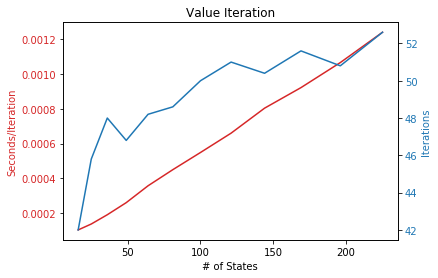

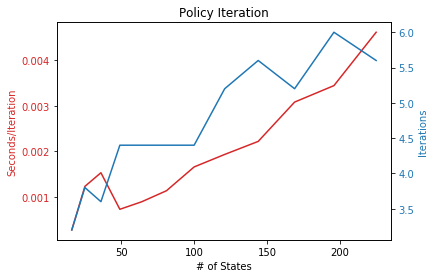

In [337]:
build_itplot(policy_times_p,pi_epochs_p,title='Value Iteration')
build_itplot(policy_times,pi_epochs,title='Policy Iteration')
#plt.plot([i**2 for i in range(4,16)],pi_epochs_p.values())
#plt.plot([i**2 for i in range(4,16)],pi_epochs.values())

In [328]:
policy_times_p

{4: [0.005181074142456055,
  0.003894805908203125,
  0.004369020462036133,
  0.0037915706634521484,
  0.004186868667602539],
 5: [0.006119728088378906,
  0.0064389705657958984,
  0.006890773773193359,
  0.0061588287353515625,
  0.0059261322021484375],
 6: [0.009685516357421875,
  0.009742021560668945,
  0.00998377799987793,
  0.009342193603515625,
  0.008229970932006836],
 7: [0.013202428817749023,
  0.01297760009765625,
  0.012935638427734375,
  0.013187646865844727,
  0.015371322631835938],
 8: [0.01951456069946289,
  0.015327215194702148,
  0.016217470169067383,
  0.01666092872619629,
  0.01623702049255371],
 9: [0.028180837631225586,
  0.020753145217895508,
  0.021366357803344727,
  0.02371668815612793,
  0.02010035514831543],
 10: [0.03696107864379883,
  0.025556087493896484,
  0.02527332305908203,
  0.025187969207763672,
  0.026165485382080078],
 11: [0.04467940330505371,
  0.03168034553527832,
  0.02839827537536621,
  0.03215312957763672,
  0.031064748764038086],
 12: [0.0561327


SFFFFFF
FFFFFFF
FFHFFFF
FFFHFFF
FFFFFFF
FFFHFFH
FFHHFFG
↓  ↓  ↓  ↓  ↓  ↓  ←  
↓  ↓  →  ↓  ↓  ↓  ←  
↓  ↓  ←  →  ↓  ↓  ←  
↓  ↓  ↓  ←  ↓  ↓  ←  
→  →  →  →  ↓  ↓  ←  
→  →  ↑  ←  ↓  ↓  ←  
→  ↑  ←  ←  →  →  ←  

↓  ↓  ↓  ↓  ↓  ↓  ←  
↓  ↓  →  ↓  ↓  ↓  ←  
↓  ↓  ←  →  ↓  ↓  ←  
↓  ↓  ↓  ←  ↓  ↓  ←  
→  →  →  →  ↓  ↓  ←  
→  →  ↑  ←  ↓  ↓  ←  
→  ↑  ←  ←  →  →  ←  
True
0.8953  0.9044  0.9135  0.9227  0.9321  0.9415  0.9321  
0.9044  0.9135  0.9227  0.9321  0.9415   0.951  0.9415  
0.9135  0.9227       0  0.9415   0.951  0.9606   0.951  
0.9227  0.9321  0.9415       0  0.9606  0.9703  0.9606  
0.9321  0.9415   0.951  0.9606  0.9703  0.9801  0.9703  
0.9227  0.9321  0.9415       0  0.9801    0.99       0  
0.9135  0.9227       0       0    0.99       1       0  
0.0859  0.1074  0.1342  0.1678  0.2097  0.2621  0.2097  
0.1074  0.1342  0.1678  0.2097  0.2621  0.3277  0.2621  
0.1342  0.1678       0  0.2621  0.3277  0.4096  0.3277  
0.1678  0.2097  0.2621       0  0.4096   0.512  0.4096  
0.

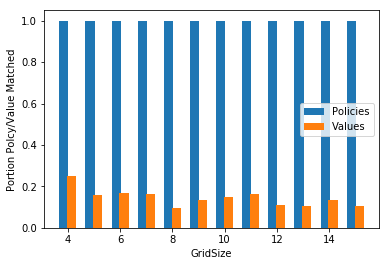

In [259]:
i,j=7,4
fz_gw_p[i][j].render()
pp=a4.matprint(a4.print_policy(pi_policy[i][j], width=i, height=i))
print('')
pv=a4.matprint(a4.print_policy(pi_policy_p[i][j],width=i,height=i))
print(pp==pv)
a4.matprint(a4.print_value(pi_V[i][j], width=i, height=i))
a4.matprint(a4.print_value(pi_V_p[i][j], width=i, height=i))

avg_val_match={}
avg_pol_match={}
for key in pi_V:
    for vals in range(len(pi_V[key])):
        avg_val_match[key]=sum(pi_V[key][vals]==pi_V_p[key][vals])/key**2
        avg_pol_match[key]=sum(pi_policy[key][vals]==pi_policy_p[key][vals])/key**2
        if np.any(pi_policy[key][vals]!=pi_policy_p[key][vals]):
            print(key,vals)
            print(a4.matprint(a4.print_policy(pi_policy_p[key][vals],width=i,height=i)))
            print(a4.matprint(a4.print_policy(pi_policy[key][vals],width=i,height=i)))
ax = plt.subplot(111)
ax.bar(np.array(list(avg_pol_match.keys()))-.15,avg_pol_match.values(),.35,align='center',label='Policies')
ax.bar(np.array(list(avg_pol_match.keys()))+.15,avg_val_match.values(),.35,align='center',label='Values')
plt.ylabel('Portion Polcy/Value Matched')
plt.xlabel('GridSize')
plt.legend(loc=5)



In [342]:
gam_env=gym.envs.toy_text.frozen_lake.FrozenLakeEnv(map_name=None,size=10,is_slippery=True,p=.8)
pi_V_gam,pi_policy_gam,pi_epochs_gam,policy_times_gam=[],[],[],[]
val_pi_V_gam,val_pi_policy_gam,val_pi_epochs_gam,val_policy_times_gam=[],[],[],[]
gams=[.25, .5, .75, .9, .9999]
for gam in gams:
    start=time.time()
    pi_V_t, pi_policy_t, pi_epochs_t=a4.policy_iteration(gam_env, epsilon=epsilon, 
                                                         gamma=gam, max_iter=max_iter, report=True)

    pi_V_gam.append(pi_V_t)
    pi_policy_gam.append(pi_policy_t)
    pi_epochs_gam.append(pi_epochs_t)
    policy_times_gam.append(time.time()-start)

    start=time.time()
    pi_V_t, pi_epochs_t = a4.valueIteration(gam_env, epsilon=epsilon, 
                                                         gamma=gam, max_iter=max_iter, report=True)
    val_policy_times_gam.append(time.time()-start)
    pi_policy_t=a4.value_to_policy(gam_env, V=pi_V_t, gamma=gam)
    val_pi_V_gam.append(pi_V_t)
    val_pi_policy_gam.append(pi_policy_t)
    val_pi_epochs_gam.append(pi_epochs_t)


Policy iteration converged after  2 epochs
Value iteration converged after  4 epochs
Policy iteration converged after  2 epochs
Value iteration converged after  6 epochs
Policy iteration converged after  3 epochs
Value iteration converged after  10 epochs
Policy iteration converged after  4 epochs
Value iteration converged after  17 epochs
Policy iteration converged after  5 epochs
Value iteration converged after  114 epochs


Text(0.5, 1.0, 'Policy Iteration Convergence Over Gammas 10x10 Grid')

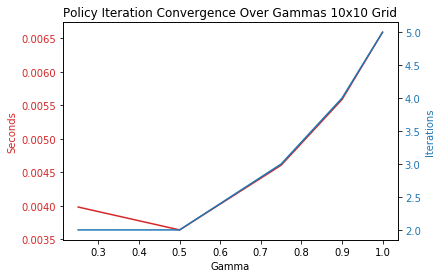

In [345]:
in_time,in_epoch=policy_times_gam,pi_epochs_gam
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Gamma')
ax1.set_ylabel('Seconds', color=color)
ax1.plot(gams,in_time, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Iterations', color=color)  # we already handled the x-label with ax1
ax2.plot(gams,in_epoch, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Policy Iteration Convergence Over Gammas 10x10 Grid')

In [353]:
np.resize(np.round(pi_V_gam[0],2),[10,10])

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.03, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.37, 0.  ]])

In [294]:
gam_env.render()
v_arrows=a4.print_policy(val_pi_policy_gam[0], width=10, height=10)
arrows=a4.print_policy(pi_policy_gam[0], width=10, height=10)
print("Value Iteration Policy")
a4.matprint(v_arrows)

print('Policy Iteration Policy')
a4.matprint(arrows)
print(v_arrows==arrows)



SFFFFFFFFH
FFFFHFFFFF
FFFFHFHFFF
FFFFFFFFFH
FFFHFFHFFF
FFFFFFHFFF
FFFFFFFHHF
FFHFHFFHHF
FFHFFHHFFF
FFFFFFFHFG
Value Iteration Policy
←  ←  ↓  ↓  →  ↓  ↓  ↓  ↓  ←  
←  ↓  ↓  ↓  ←  ↓  →  ↓  ↓  ←  
↓  ↓  ↓  ↓  ←  ↓  ←  ↓  ↓  ←  
→  →  →  →  →  →  →  ↓  ↓  ←  
→  →  ↑  ←  →  ↑  ←  ↓  ↓  ↓  
→  →  →  →  →  ↑  ←  →  →  ↓  
→  →  →  →  →  ↑  ←  ←  ←  ↓  
→  ↑  ←  ↑  ←  ↑  ←  ←  ←  ↓  
→  ↑  ←  ↑  ←  ←  ←  →  ↓  ↓  
→  →  →  ↑  ←  ←  ←  ←  →  ←  
Policy Iteration Policy
←  ←  ↓  ↓  →  ↓  ↓  ↓  ↓  ←  
←  ↓  ↓  ↓  ←  ↓  →  ↓  ↓  ←  
↓  ↓  ↓  ↓  ←  ↓  ←  ↓  ↓  ←  
→  →  →  →  →  →  →  ↓  ↓  ←  
→  →  ↑  ←  →  ↑  ←  ↓  ↓  ↓  
←  →  →  →  →  ↑  ←  →  →  ↓  
←  ←  →  →  →  ↑  ←  ←  ←  ↓  
←  ←  ←  ↑  ←  ↑  ←  ←  ←  ↓  
←  ←  ←  ←  ←  ←  ←  →  ↓  ↓  
←  ←  ←  ←  ←  ←  ←  ←  →  ←  
[[ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  

In [311]:
gamma = .99
e1=gym.envs.toy_text.taxi.TaxiEnv()
e1.render()
epsilon=.01
start=time.time()
pi_V_t, pi_policy_t, pi_epochs_t=a4.policy_iteration(e1, epsilon=epsilon, 
                                                     gamma=gam, max_iter=max_iter, report=True)


policy_times_tax=(time.time()-start)

start=time.time()
pi_V_t_v, pi_epochs_t_v = a4.valueIteration(e1, epsilon=epsilon, 
                                                     gamma=gam, max_iter=max_iter, report=True)
val_policy_times_tax=time.time()-start
pi_policy_t_v=a4.value_to_policy(gam_env, V=pi_V_t_v, gamma=gam)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Policy iteration converged after  16 epochs


In [313]:
print(policy_times_tax,val_policy_times_tax)
print(pi_epochs_t, pi_epochs_t_v)
# taxi_row, taxi_col, pass_loc, dest_idx
#     actions:
#     - 0: south
#     - 1: north
#     - 2: east
#     - 3: west
#     - 4: pickup
#     - 5: dropoff 
#print([i for i in e1.decode(4)])

0.30135035514831543 30.85001802444458
16 10001


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


False

In [369]:
env.render()

  (Left)
SHFF
FFFF
FFFF
FFFG


In [ ]:
reload(a4)

test,epis=a4.Qlearning(env, qepsilon=.9, lr=.8, decay=.99,qgamma=.95, episodes=10, initial=0)
print(epis)
a4.Q_to_policy(test)


{4: [8.145716905593872,
  8.265347480773926,
  10.991240978240967,
  11.539928674697876,
  8.109718561172485],
 5: [14.902239084243774,
  13.124739646911621,
  9.165226936340332,
  11.608461618423462,
  13.42587423324585],
 6: [13.140313148498535,
  13.921045541763306,
  7.886210203170776,
  11.295881271362305,
  12.675994634628296],
 7: [23.53558349609375,
  21.446422338485718,
  28.127304077148438,
  16.985811710357666,
  17.664243698120117],
 8: [30.521568059921265,
  24.45454502105713,
  12.84882664680481,
  20.85404109954834,
  32.16872787475586],
 9: [22.31390929222107, 35.23332953453064]}

In [ ]:
reload(a4)
epsilon = 1e-8 # convergence threshold for policy/value iteration
gamma = 0.8 # discount parameter for past policy/value iterations
max_iter = 10000 # maximum iterations for slowly converging policy/value iteration 

# Qlearning(env, rH=0, rG=1, rF=0, qepsilon=0.1, lr=0.8, gamma=0.95, episodes=10000)
qepsilon = 0.99 # epsilon value for the Q-learning epsilon greedy strategy
decay=.99
lr = 0.75 # Q-learning rate
qgamma = 0.95 # Q-Learning discount factor
episodes = int(10000) # number of Q-learning episodes
initial = 0 # value to initialize the Q grid
q_tol=.0001

Q,Q_policy,Q_epochs,Q_time={},{},{},{}
#Q_time_timeit = %timeit -o a4.Qlearning(env, qepsilon, lr, decay,qgamma, episodes, initial)
for size in fz_gw_p:
    Q[size],Q_policy[size],Q_epochs[size],Q_time[size]=[],[],[],[]
    for env in fz_gw_p[size]:
        
        start=time.time()
        Q_t, Q_epochs_t = a4.Qlearning(env, qepsilon,q_tol, lr,decay, qgamma, episodes, initial,report=True)
        end=time.time()
        maxQ = np.max(Q_t,axis=1)

        Q_policy_t = a4.Q_to_policy(Q_t)

        Q_policy_arrows_t = a4.print_policy(Q_policy_t, width=size, height=size)
    
        Q_policy[size].append(Q_policy_t)
        Q_epochs[size].append(Q_epochs_t)
        Q_time[size].append(end-start)
        Q[size].append(Q_t)
    

Q-Learning converged after  206 epochs
Q-Learning converged after  159 epochs
Q-Learning converged after  243 epochs


In [47]:
i=4
j=1
print(Q_epochs)
print(i)
print(fz_gw_p[i][j].render())
print(np.resize(pi_policy_p[i][j],[i,i]))
np.resize(Q_policy[i][j],[i,i])

{4: [3, 10000, 10000, 10000, 10000], 5: [10000, 10000, 10000, 10000, 10000], 6: [10000, 10000, 1611, 10000, 10000], 7: [10000, 10000, 10000, 10000, 10000], 8: [10000, 10000, 859, 10000, 10000], 9: [10000, 10000, 10000, 10000, 10000], 10: [605, 10000, 10000, 10000, 10000], 11: [10000, 10000, 10000, 10000, 10000], 12: [10000, 10000, 10000, 10000, 1105], 13: [10000, 10000, 10000, 1158, 10000], 14: [10000, 10000, 10000, 10000, 10000], 15: [1441, 1694, 1383, 10000, 1373]}
4
  (Right)
SFHF
FFFF
FFFF
FFFG
None
[[1 0 0 2]
 [1 1 1 1]
 [1 2 1 1]
 [1 2 2 0]]


array([[2, 0, 0, 2],
       [1, 2, 1, 0],
       [0, 1, 1, 1],
       [1, 2, 2, 0]])

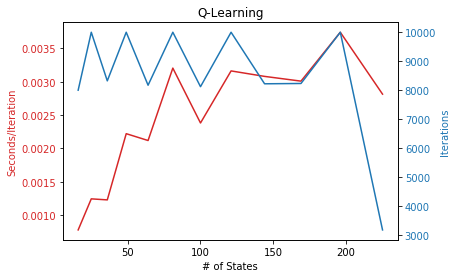

In [26]:
build_itplot(Q_time,Q_epochs,title='Q-Learning')


In [357]:
reload(a4)
epsilon = 1e-8 # convergence threshold for policy/value iteration
gamma = 0.8 # discount parameter for past policy/value iterations
max_iter = 10000 # maximum iterations for slowly converging policy/value iteration 

# Qlearning(env, rH=0, rG=1, rF=0, qepsilon=0.1, lr=0.8, gamma=0.95, episodes=10000)
qepsilon = 0.99 # epsilon value for the Q-learning epsilon greedy strategy
decay=.9999
lr = 0.75 # Q-learning rate
qgamma = 0.9 # Q-Learning discount factor
episodes = int(10000) # number of Q-learning episodes
initial = 0 # value to initialize the Q grid
q_tol=.0001

Q,Q_policy,Q_epochs,Q_time={},{},{},{}
#Q_time_timeit = %timeit -o a4.Qlearning(env, qepsilon, lr, decay,qgamma, episodes, initial)
for size in fz_gw_p:
    Q[size],Q_policy[size],Q_epochs[size],Q_time[size]=[],[],[],[]
    for env in fz_gw_p[size]:
        
        start=time.time()
        Q_t, Q_epochs_t = a4.Qlearning(env, qepsilon,q_tol, lr,decay, qgamma, episodes, initial,report=True)
        end=time.time()
        maxQ = np.max(Q_t,axis=1)

        Q_policy_t = a4.Q_to_policy(Q_t)

        Q_policy_arrows_t = a4.print_policy(Q_policy_t, width=size, height=size)
    
        Q_policy[size].append(Q_policy_t)
        Q_epochs[size].append(Q_epochs_t)
        Q_time[size].append(end-start)
        Q[size].append(Q_t)
    

--Board--

SFFFFFFF
HFFFHHHF
FFFFFFFF
FHFHFFFF
FHFFFFFF
HHFFFFFF
FHFFHFFF
FFFFFFFG

--Actions for Position to the Left of the Goal--
{0: [(0.3333333333333333, 54, -0.2, False),
     (0.3333333333333333, 61, -0.2, False),
     (0.3333333333333333, 62, -0.2, False)],
 1: [(0.3333333333333333, 61, -0.2, False),
     (0.3333333333333333, 62, -0.2, False),
     (0.3333333333333333, 63, 1, True)],
 2: [(0.3333333333333333, 62, -0.2, False),
     (0.3333333333333333, 63, 1, True),
     (0.3333333333333333, 54, -0.2, False)],
 3: [(0.3333333333333333, 63, 1, True),
     (0.3333333333333333, 54, -0.2, False),
     (0.3333333333333333, 61, -0.2, False)]}

--Reward Values at Each State--
-0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  
  -1  -0.2  -0.2  -0.2    -1    -1    -1  -0.2  
-0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  
-0.2    -1  -0.2    -1  -0.2  -0.2  -0.2  -0.2  
-0.2    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  
  -1    -1  -0.2  -0.2  -0.2  -0.2  -0.2  -0.2  
-0.2    -1  -0.2  -0

In [117]:
e1=gym.envs.toy_text.taxi.TaxiEnv()
e1.observation_space.n

500

In [112]:
bj=gym.envs.toy_text.blackjack.BlackjackEnv()
bj.observation_space.n=bj.observation_space[0].n*bj.observation_space[1].n*bj.observation_space[2].n
bj.P

In [29]:

pi_V, pi_policy, pi_epochs = a4.policy_iteration(fz_gw[10], epsilon=epsilon, gamma=gamma, max_iter=max_iter, report=True)

# Display values
a4.matprint(a4.print_value(pi_V, width=10, height=10))
print(fz_gw[10].render())
pi_policy_arrows = a4.print_policy(pi_policy, width=10, height=10)
# Display policy
a4.matprint(pi_policy_arrows)

Policy iteration converged after  18 epochs
0.0225  0.0281  0.0352       0   0.055  0.0687  0.0859  0.1074  0.0859       0  
0.0281  0.0352   0.044   0.055  0.0687  0.0859  0.1074  0.1342  0.1074  0.0859  
0.0352   0.044   0.055  0.0687  0.0859  0.1074  0.1342  0.1678       0  0.1074  
 0.044   0.055       0  0.0859  0.1074       0  0.1678  0.2097  0.1678  0.1342  
 0.055  0.0687       0  0.1074  0.1342  0.1678  0.2097  0.2621  0.2097  0.1678  
0.0687  0.0859  0.1074       0  0.1678  0.2097  0.2621  0.3277  0.2621       0  
0.0859       0  0.1342  0.1678       0       0  0.3277  0.4096       0    0.64  
0.1074  0.1342  0.1678  0.2097       0  0.3277       0   0.512    0.64     0.8  
0.1342  0.1678  0.2097  0.2621  0.3277  0.4096       0    0.64       0       1  
     0  0.2097  0.2621  0.3277  0.4096   0.512    0.64     0.8       1       0  

SFFHFFFFFH
FFFFFFFFFF
FFFFFFFFHF
FFHFFHFFFF
FFHFFFFFFF
FFFHFFFFFH
FHFFHHFFHF
FFFFHFHFFF
FFFFFFHFHF
HFFFFFFFFG
None
↓  ↓  ↓  ←  ↓  ↓  ↓  ↓  ↓  ←  

In [121]:
vi_V, vi_epochs = a4.valueIteration(e1, epsilon=epsilon, gamma=gamma, max_iter=max_iter, report=True)

# display value function:
a4.matprint(a4.print_value(vi_V, width=10, height=50))

vi_policy = a4.value_to_policy(env, V=vi_V, gamma=gamma)

#vi_policy_arrows = a4.print_policy(vi_policy, width=size, height=size)
# display policy
#a4.matprint(vi_policy_arrows)

Value iteration converged after  59 epochs
41.6667   7.2334  14.1147   4.7867  -1.7931   7.2334  -2.9476  -0.9914   2.8294  -1.7931  14.1147  -0.9914  -2.9476  -1.7931  -2.9476   4.7867  53.3333  10.2917  18.8933   7.2334  32.3333   4.7867  10.2917   2.8294  -0.9914  10.2917  -2.4345   0.0108   1.2635  -2.4345  10.2917  -1.7931  -2.4345  -0.9914  -2.4345   7.2334  41.6667  14.1147  14.1147  10.2917  14.1147   0.0108   2.8294  -0.9914   2.8294  24.8667   0.0108   4.7867   0.0108  -2.9476  
 7.2334  -2.4345  -1.7931   0.0108  -1.7931  10.2917  18.8933  32.3333  10.2917  14.1147  10.2917  -0.9914   1.2635  -1.7931   4.7867  32.3333   1.2635   7.2334  -0.9914  -3.3581   4.7867  -2.9476  -0.9914   1.2635  -0.9914  14.1147  14.1147  41.6667   7.2334  18.8933   7.2334  -1.7931   0.0108  -2.4345   7.2334  41.6667   2.8294  10.2917  -1.7931  -3.6865   2.8294  -3.3581  -1.7931   0.0108  -1.7931  10.2917  10.2917  53.3333   4.7867  14.1147  
32.3333   4.7867  10.2917   2.8294  -0.9914  10.2917  -

In [62]:

Q = a4.Qlearning(env, qepsilon, lr, qgamma, episodes)
print('--Q with all options--')
a4.matprint(Q)

maxQ = np.max(Q,axis=1)
print('\n--argmax(Q) in grid order--')
a4.matprint(a4.print_value(maxQ, width=size, height=size))

Q_policy = a4.Q_to_policy(Q)

Q_policy_arrows = a4.print_policy(Q_policy, width=size, height=size)
print('\n--Policy Matrix--')
a4.matprint(Q_policy_arrows)

--Q with all options--
 -2.97369  -2.93386   -2.99108   -2.99486  
 -2.98629  -2.99057   -2.93948   -2.97205  
 -2.91594  -2.92853   -2.75667   -2.91614  
 -2.78965  -2.87875    -2.7841    -2.9457  
 -2.95483  -2.96468   -2.97633   -2.97167  
 -2.98315  -2.96034   -2.89808   -2.96992  
 -2.95398  -2.94526   -2.68728   -3.06257  
  -3.0689  -1.85271   -2.93627   -2.94644  
 -2.64197  -2.98246   -2.97101   -2.99727  
 -2.63272  -2.91044   -2.81296   -2.93986  
  -2.7993    -2.872   -2.76956   -2.84077  
 -2.94018  -2.80315   -2.82991    -2.7936  
 -2.89444  -2.85468    -2.7889   -2.88407  
 -2.95462  -2.88647   -2.89953   -2.92629  
 -2.74068  -2.68919   -2.76036   -2.90955  
 -2.62492  -1.07736   -2.61882   -2.88867  
  -2.8744  -2.85901   -2.46122    -2.8718  
 -2.76465   -2.8803   -2.67353   -2.86192  
 -2.77845  -2.57346   -2.68842   -2.06153  
       -1        -1         -1         -1  
 -2.33407   -2.6172    -2.7946   -2.61944  
 -2.65642  -2.61136   -2.64587   -2.61818  
 -2.64792

In [63]:
ebj=bj.BlackjackEnv()
vi_V, vi_epochs = a4.valueIteration(ebj, epsilon=epsilon, gamma=gamma, max_iter=max_iter, report=True)


AttributeError: 'Tuple' object has no attribute 'n'